In [1]:
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(str(repo.working_tree_dir) + '/src')

**Data Preperation and Visualisation**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from demos import prepare_data, plot_data, plot_revenue_per_weekday, plot_avg_revenue_per_weekday, create_test_and_train_set, plot_revenue

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

In [3]:
wheater_path = repo.working_tree_dir + '/data/wheater_data.csv' 
revenue_path = repo.working_tree_dir + '/data/revenue_data.csv' 
df = prepare_data(wheater_path, revenue_path)
train_df, test_df = create_test_and_train_set(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:170: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.yesterday_revenue.iloc[0] = df.revenue.iloc[0]
/Users/jonasfischer/Libra

In [4]:
df.sort_values('bridge_day', ascending=False).head()

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,...,holiday_all_germany,national_and_holiday,DOW,yesterday_revenue,three_day_revenue,week_revenue,bridge_day,day,month,year
date,,,,,,,,,,,,,,,,,,,,,
2023-10-02,18.1,12.7,25.3,0.0,120,7.6,1022.0,0,0,4848,...,0,0,0,5185.0,4018.000000,2742.142857,1,2,10,2023
2022-06-17,22.0,14.2,28.5,0.0,116,5.7,1023.6,0,1,3471,...,0,0,4,4278.0,2326.000000,2628.285714,1,17,6,2022
2022-10-31,14.4,11.1,19.4,0.0,96,4.5,1019.0,1,1,3837,...,1,1,0,4633.0,3507.000000,2541.142857,1,31,10,2022
2024-05-31,13.6,11.8,16.3,2.0,297,11.6,1009.9,0,1,3485,...,0,0,4,3185.0,2200.333333,2984.571429,1,31,5,2024
2024-05-10,15.9,9.2,21.8,0.0,64,9.7,1022.4,0,0,4313,...,0,0,4,4362.0,2610.000000,3049.857143,1,10,5,2024


/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=7)


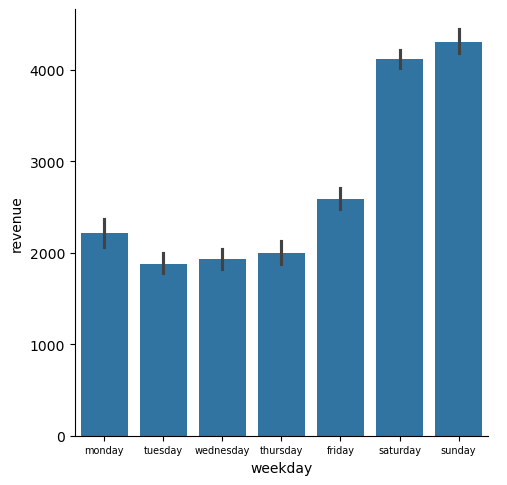

In [5]:
plot_avg_revenue_per_weekday(df)

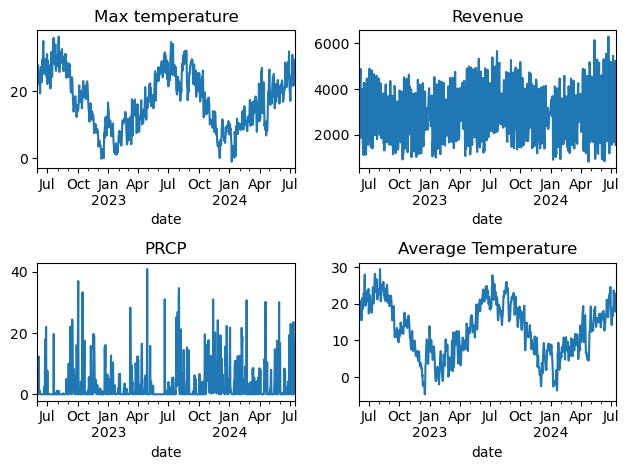

In [6]:
plot_data(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:282: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=7)


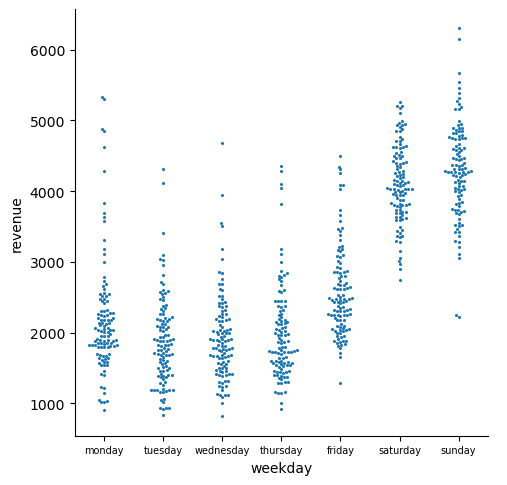

In [7]:
plot_revenue_per_weekday(df)

**Optimization with Optuna and Time Servies Cross-Validation**

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from src.model import time_series_cross_validation, time_series_cross_validation_lgbm
from src.demos import split_X_Y
import lightgbm as lgb

X_train, Y_train= split_X_Y(train_df)
X_test, Y_test = split_X_Y(test_df)

In [9]:
import optuna
from src.model import time_series_cross_validation
import pickle

In [10]:
def objectiveTimeSeriesCV(trial):
    params = {
    "objective": "regression",
    # "metric": "rmse",
    "n_estimators": trial.suggest_int('n_estimators', 200,1000),
    "verbosity": -1,
    "bagging_freq": 1,
    'max_depth': trial.suggest_int('max_depth', 3,10),
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True), #Add regularization, because LGBM is overfitting
    # 'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
    "num_leaves": trial.suggest_int("num_leaves", 2, 200),
    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
}

    err = time_series_cross_validation_lgbm(train_df, params, cv=4, metric=mean_squared_error)
    return err

In [11]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objectiveTimeSeriesCV, n_trials=100)

[I 2024-09-16 22:48:20,834] A new study created in memory with name: no-name-dc46935a-b45f-4674-b3dc-549374a4cc7c
100%|██████████| 4/4 [00:00<00:00,  5.36it/s]
[I 2024-09-16 22:48:21,613] Trial 0 finished with value: 807134.1406587809 and parameters: {'n_estimators': 953, 'max_depth': 6, 'reg_alpha': 2.356672364563121, 'learning_rate': 0.0017449554776347719, 'num_leaves': 11, 'subsample': 0.42363273415794644, 'colsample_bytree': 0.6896547058635545, 'min_data_in_leaf': 51}. Best is trial 0 with value: 807134.1406587809.
100%|██████████| 4/4 [00:00<00:00, 17.30it/s]
[I 2024-09-16 22:48:21,854] Trial 1 finished with value: 1060327.6880881607 and parameters: {'n_estimators': 359, 'max_depth': 9, 'reg_alpha': 0.0035462430566087356, 'learning_rate': 0.0614806916719089, 'num_leaves': 83, 'subsample': 0.354131383246496, 'colsample_bytree': 0.26355473088249565, 'min_data_in_leaf': 71}. Best is trial 0 with value: 807134.1406587809.
100%|██████████| 4/4 [00:00<00:00,  8.76it/s]
[I 2024-09-16 22:

In [12]:
best_params = study.best_params
print(best_params)

{'n_estimators': 630, 'max_depth': 3, 'reg_alpha': 0.07370930373091282, 'learning_rate': 0.005289898940612358, 'num_leaves': 134, 'subsample': 0.8254942708093671, 'colsample_bytree': 0.8515788219316591, 'min_data_in_leaf': 2}


In [13]:
lgb_model_rs = lgb.LGBMRegressor(**best_params)
lgb_model_rs.fit(X_train, Y_train)

LGBMRegressor(colsample_bytree=0.8515788219316591,
              learning_rate=0.005289898940612358, max_depth=3,
              min_data_in_leaf=2, n_estimators=630, num_leaves=134,
              reg_alpha=0.07370930373091282, subsample=0.8254942708093671)

In [14]:
predictions_rs = lgb_model_rs.predict(X_test)

In [15]:
print(f'MAPE: {mean_absolute_percentage_error(Y_test, predictions_rs)}')
print(f'MSE {mean_squared_error(Y_test, predictions_rs)}')

MAPE: 0.2020424693932674
MSE 271310.0168965676


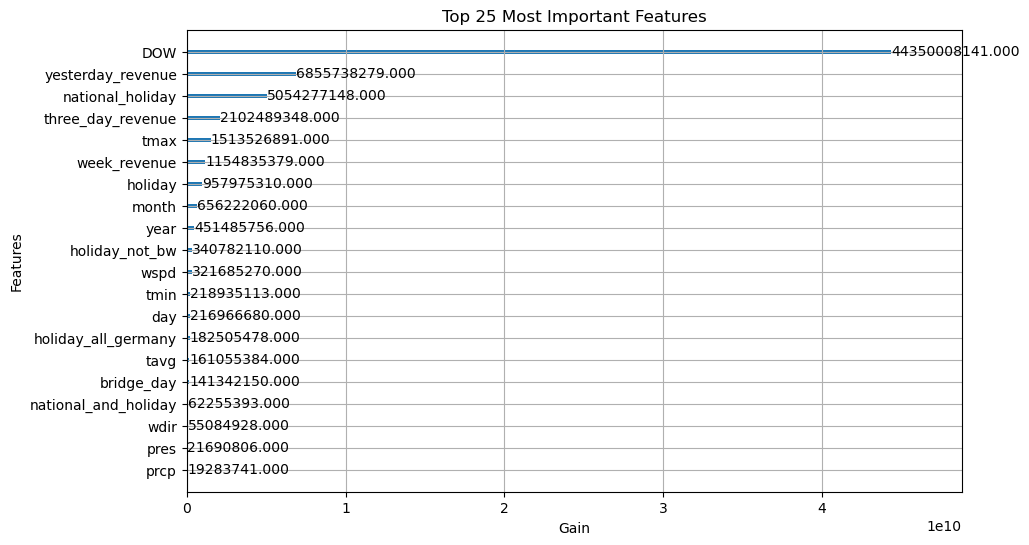

In [16]:
top_n = 25
# Create feature names
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(lgb_model_rs, ax=ax, importance_type='gain',
                    max_num_features=top_n)
# plt.yticks(range(top_n), xgb_model.feature_names[:top_n])
plt.xlabel('Gain')
plt.title(f'Top {top_n} Most Important Features')
plt.show()

**Visualization of the optimization process**

In [17]:
import matplotlib.pyplot as plt
import plotly

In [18]:
optuna.visualization.plot_optimization_history(study)

In [19]:
optuna.visualization.plot_param_importances(study)

In [20]:
optuna.visualization.plot_contour(study, params=['colsample_bytree', 'learning_rate', 'min_data_in_leaf', 'subsample'])

In [21]:
pred_test = lgb_model_rs.predict(X_test)

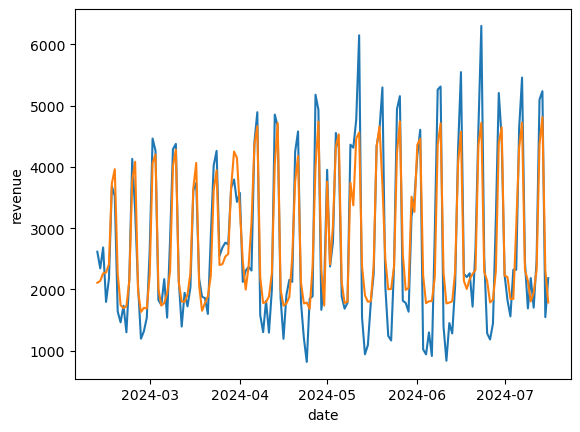

In [22]:
plot_revenue(test_df, pred_test)

**Recursive Feature Elimination**

In [23]:
from sklearn.feature_selection import RFE

In [60]:
rfe = RFE(lgb.LGBMRegressor(**best_params), n_features_to_select=17)

In [61]:
rfe.fit(X_train, Y_train)
rfe_pred = rfe.predict(X_test)

In [62]:
print(f'MAPE: {mean_absolute_percentage_error(Y_test, rfe_pred)}')
print(f'MSE {mean_squared_error(Y_test, rfe_pred)}')

MAPE: 0.20174515245555996
MSE 271377.3798161828


**Save and load**

In [26]:
file_name = "lgb_regressor.pkl"

In [27]:
xgb_model_rs = pickle.load(open(file_name, "rb"))

In [28]:
import pickle
# xgb_model_rs = xgb.XGBRegressor()
# save
pickle.dump(lgb_model_rs, open(file_name, "wb"))